In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
from pyntcloud import PyntCloud
from matplotlib import pyplot as plt
from scipy.sparse import find, csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import loadlib
from smutsia.utils.viz import plot_cloud
from smutsia.point_cloud import filter_points
from smutsia.point_cloud.io import load_pyntcloud
from smutsia.point_cloud.normals import get_normals
from smutsia.utils.graph import cloud_knn_graph, cloud_spherical_graph, merge_graphs
from smutsia.morphology.segmentation.metrics import z_nz_dist
from smutsia.morphology.segmentation import quasi_flat_zones

In [3]:
basedir = '../../data/semantickitti/dataset/sequences/'
sequences = sorted(os.listdir(basedir))
plyfiles = sorted(glob(os.path.join(basedir, sequences[8], 'velodyne', '*.bin')))

In [4]:
# nidx = np.random.randint(len(plyfiles))
nidx = 3721
print(nidx)
cloud = load_pyntcloud(plyfiles[nidx], add_label=True)
fpoints = filter_points(cloud.points.values, height_range=(-4.0, np.inf))
cloud = PyntCloud(pd.DataFrame(fpoints, columns=list(cloud.points)))

3721


In [17]:
plot_cloud(cloud.xyz, scalars=cloud.points.labels.values, cmap=plt.cm.Set1, interact=True)

Selected Points: 
[25180 25181 25182]
Coordinates xyz: 
[[ 6.39154816 18.93701172 -0.59236157]
 [ 6.32815981 18.94792938 -0.59144968]
 [ 6.27074146 18.97585678 -0.59255755]]
Labels: 
[72. 72. 72.]


## Define 3D Graph

In [6]:
# initialise k-nn graph
knn_graph = cloud_knn_graph(cloud.xyz, k = 10)
# initialise Spherical graph
spherical_graph = cloud_spherical_graph(cloud.xyz, res_pitch=64, res_yaw=2048, thresold=3.0)
# 3D graph is obtained as merge of the two graphs
graph = merge_graphs([knn_graph, spherical_graph])

# plot 3D Graph
plot_cloud(xyz=cloud.xyz, graph=graph)

In [7]:
%load_ext line_profiler

In [8]:
%lprun -f cloud_spherical_graph cloud_spherical_graph(cloud.xyz, res_pitch=64, res_yaw=2048, thresold=3.0)

*** KeyboardInterrupt exception caught in code being profiled.

In [9]:
sg = cloud_spherical_graph(cloud.xyz, res_pitch=64, res_yaw=2048, thresold=3.0)
plot_cloud(cloud.xyz, graph=sg)

In [11]:
normals = get_normals(cloud, method='pca', k=10)
## visualise normals
# cloud.points['red'] = (np.abs(normals[:, 0]) * 255).astype(np.uint8)
# cloud.points['green'] = (np.abs(normals[:, 1]) * 255).astype(np.uint8)
# cloud.points['blue'] = (np.abs(normals[:, 2]) * 255).astype(np.uint8)
# cloud.plot(notebook=False, initial_point_size=0.03)

#### Choose right parameters for the logistic function

In the following we are going to compute weights between two points $p_1$ and $p_2$ as:
$$w(p_1, p_2) = \Big| \frac{z(p_1)}{f(n_z(p_1))} - \frac{z(p_2)}{f(n_z(p_2))} \Big|,$$
where $$f(x) = \frac{1}{1 - exp(-k(x-x_0))}.$$
In the following we are doing some plots to test the good values to choose for $k$ and $x_0$. 

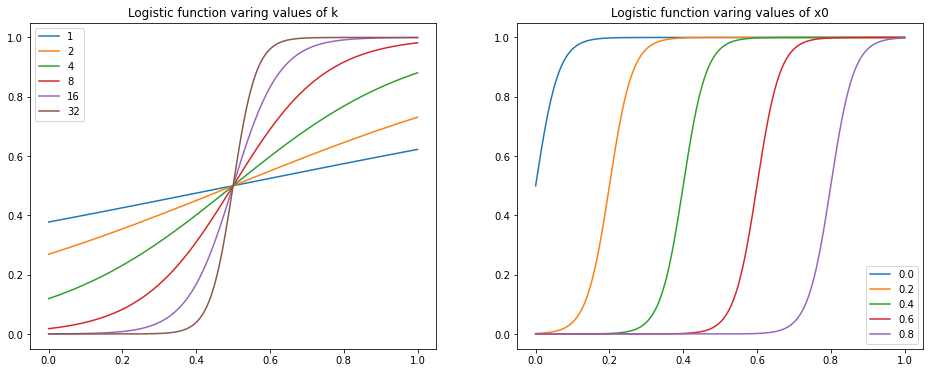

In [12]:
from smutsia.morphology.segmentation.metrics import _logistic_function
x = np.linspace(0, 1, 1000)
k = [1, 2, 4, 8, 16, 32]
x0 = 1/2
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
for h in k:
    ax[0].plot(x, _logistic_function(x, x0, 1, h))
ax[0].set_title("Logistic function varing values of k")
ax[0].legend(k)


x0 = np.arange(0, 10,2)/10

for xx in x0:
    ax[1].plot(x, _logistic_function(x, xx, 1, 32))
ax[1].set_title("Logistic function varing values of x0")
ax[1].legend(x0)

#### Initialise weighted graph with $x_0=0.7$ and $k=16$

In [13]:
# adding weights to 3D graph
src, dst, _ = find(graph)
# the weights are z / n_z
weigths = z_nz_dist(cloud.xyz, normals, src, dst)
# weighted 3D graph
wg = csr_matrix((weigths, (src, dst)), shape=graph.shape)

In [14]:
# MST
t = minimum_spanning_tree(wg)
plot_cloud(cloud.xyz, graph=t)

In [15]:
# lambda quasi flat zones
cc = quasi_flat_zones(wg, threshold=0.30, debug_info=True)
plot_cloud(cloud.xyz, scalars=cc, cmap=plt.cm.tab20)

Number of connected components:  69582


### Find a strategy to merge connected components

[TODO] Strategies to test:

* [ ] First strategy to test could be to consider only the biggest connected components. As first test we consider only cc bigger than 100 points, and try to merge them using ransac over aggregated informations, as for example max_z, min_z, mean_z, std_z, nz_mean, nz_std.



In [18]:
# counting cc ans selecting only those bigger than 100 points
unique, count = np.unique(cc, return_counts=True)
iargsort = count.argsort()[::-1]
icount = count[iargsort]
sel_cc = unique[iargsort][icount > 100]

In [19]:
# we can consider to use the same metric to compare different cc, connecting all the cc together
z_max = np.zeros_like(sel_cc).astype(np.float32)
z_min = np.zeros_like(sel_cc).astype(np.float32)
z_mean = np.zeros_like(sel_cc).astype(np.float32)
z_std = np.zeros_like(sel_cc).astype(np.float32)
nz_mean = np.zeros_like(sel_cc).astype(np.float32)
nz_std = np.zeros_like(sel_cc).astype(np.float32)

for n, u in enumerate(sel_cc):
    z_max[n] = cloud.xyz[cc==u, 2].max()
    z_min[n] = cloud.xyz[cc==u, 2].min()
    z_mean[n] = cloud.xyz[cc==u, 2].mean()
    z_std[n] = cloud.xyz[cc==u, 2].std()
    nz_mean[n] = np.abs(normals[cc==u, 2]).mean()
    nz_std[n] = np.abs(normals[cc==u, 2]).std()    

In [29]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor()
X = np.c_[z_max, z_min, z_mean, z_std, nz_mean, nz_std]
ransac.fit(X, np.ones(len(X)))
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

ValueError: RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).

In [150]:
## for each cc in sel_cc i want to estimate the kl divergence against the biggest connected componet
## assuming that in each cc the z are normally distributed we can compute the KL(p|q) using the following formula
## KL(p|q) = log(sigma_q/sigma_p) + (sigma_p**2 + (mu_p - mu_q)**2) / (2 * sigma_q)**2 - 0.5
kl = np.zeros(len(sel_cc))
for n in range(len(sel_cc)):
    mu_1 = z[0]
    mu_2 = z[n]
    sigma_1 = std_z[0]
    sigma_2 = std_z[n]
    kl[n] = np.log(sigma_2/sigma_1) + (sigma_1**2 + (mu_1 - mu_2)**2) / (2 * sigma_2)**2 - 0.5
    

In [202]:
def kl_gauss_div(mu_1, mu_2, sigma_1, sigma_2):
    return np.log(sigma_2/sigma_1) + (( sigma_1**2 + (mu_1 - mu_2)**2) / (2* (sigma_2)**2)) - 0.5

In [187]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [194]:
cc_edges[weights.argmin()]

array([14, 18])

In [204]:
sigma_1 = std_z[14]
sigma_2 = std_z[18]
mu_1 = z[14]
mu_2 = z[18]
# np.log(sigma_2/sigma_1)
mu_1, mu_2, sigma_1, sigma_2, kl_gauss_div(mu_1, mu_2, sigma_1, sigma_2)

(-1.1553305, -1.1626029, 0.1207765, 0.08684109, 0.1407734791606775)

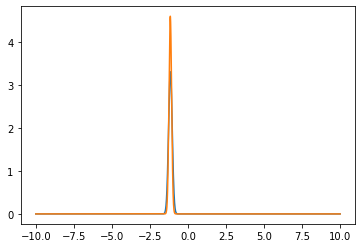

In [201]:
plt.plot(x, norm.pdf(x, z[14], std_z[14]))
plt.plot(x, norm.pdf(x, z[18], std_z[18]))

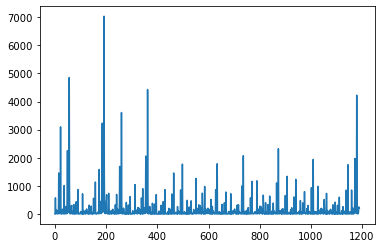

In [205]:
cc_ids = np.arange(len(sel_cc))
cc_edges = np.array(np.meshgrid(cc_ids, cc_ids)).T.reshape(-1,2)
cc_edges = cc_edges[cc_edges[:,0]!=cc_edges[:,1]]
src, dst = cc_edges[:, 0], cc_edges[:, 1]
log_nz = _logistic_function(nz, x0=0.7, L=1, k=16)
# weights = np.abs(z[src]  - z[dst])
weights = kl_gauss_div(z[src], z[dst], std_z[src], std_z[dst])
plt.plot(weights)
cc_graph = csr_matrix((weights, (src, dst)), shape=(len(sel_cc), len(sel_cc)))
cc_mst = minimum_spanning_tree(cc_graph)

In [212]:
from smutsia.utils import shuffle_labels

sub_cc = quasi_flat_zones(cc_graph, 0.6, debug_info=True)
merged_labels = np.zeros_like(cc)
for n, u in enumerate(sel_cc):
    merged_labels[cc==u] = sub_cc[n] + 1


plot_cloud(cloud.xyz, scalars=shuffle_labels(merged_labels), cmap=plt.cm.tab20, interact=True)

Number of connected components:  13


Selected Points: 
[84985 87002 87003 87004 87005 87006 87007 87008 90769 90770 90771 90772
 90773 90774 90775 90777 90779 90780 90781]
Coordinates xyz: 
[[-0.61666828 -3.03351235 -0.60338449]
 [-0.57070231 -2.90664816 -0.59716797]
 [-0.57408428 -2.95562077 -0.60825253]
 [-0.56232417 -2.94665718 -0.60623795]
 [-0.56858748 -2.99262166 -0.61731684]
 [-0.56592995 -3.02161956 -0.62336695]
 [-0.55920404 -3.03163505 -0.62538451]
 [-0.55453843 -3.05464005 -0.6304242 ]
 [-0.48974624 -2.67187023 -0.59476888]
 [-0.48706293 -2.69486928 -0.59980935]
 [-0.48539445 -2.72286248 -0.60685825]
 [-0.48675659 -2.7638402  -0.61792904]
 [-0.48694456 -2.78383136 -0.62296361]
 [-0.48124745 -2.7978425  -0.62598842]
 [-0.47252473 -2.79986644 -0.62599283]
 [-0.46212804 -2.83188152 -0.63404882]
 [-0.45257074 -2.84990096 -0.63808054]
 [-0.44890806 -2.87590098 -0.64412522]
 [-0.44420993 -2.89490557 -0.64915794]]
Labels: 
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Selected Points: 
[42154]
Coordinates xyz: 
[[-0.5214465

ERROR:root:Input port 0 of algorithm vtkAppendFilter(0x7fd87c039070) has 0 connections but is not optional.


Selected Points: 
[44874 44875 44876 44877 44878 44879]
Coordinates xyz: 
[[-16.23073959  -3.71955848  -1.34983838]
 [-16.2172184   -3.7706964   -1.34899473]
 [-16.20170021  -3.82184052  -1.34915173]
 [-16.2021904   -3.87591195  -1.35030937]
 [-16.19543266  -3.90197992  -1.35038865]
 [-16.21094131  -3.95998192  -1.35354984]]
Labels: 
[4 4 4 4 4 4]


Selected Points: 
[48316 48318 48319 48320 48321 48323]
Coordinates xyz: 
[[ 3.67152572  9.91441345 -0.92054135]
 [ 3.62624621  9.88935757 -0.91655558]
 [ 3.61182666  9.94534492 -0.92165995]
 [ 3.65338111 10.10540867 -0.93886054]
 [ 3.52101898  9.9422369  -0.91776276]
 [ 3.48568225  9.94519329 -0.9168095 ]]
Labels: 
[4 4 4 4 4 4]
Selected Points: 
[101074 102899 102900]
Coordinates xyz: 
[[ 0.23793276  4.10723782 -1.20699155]
 [ 0.24712032  4.11418295 -1.25698745]
 [ 0.22897281  4.05117702 -1.23591793]]
Labels: 
[4 4 4]
Selected Points: 
[82884 82885 82886 82887 84987 84988 84989 84990 84992 87009 87010]
Coordinates xyz: 
[[-0.68740988 -3.0963304  -0.59348953]
 [-0.69380403 -3.1532917  -0.6065883 ]
 [-0.69114083 -3.18129182 -0.611637  ]
 [-0.68948573 -3.21328568 -0.6186924 ]
 [-0.61240554 -3.09950042 -0.61849868]
 [-0.61177188 -3.13748956 -0.62656409]
 [-0.60711884 -3.16249323 -0.63260716]
 [-0.60041606 -3.1765089  -0.63463134]
 [-0.58178157 -3.16356778 -0.63060963]
 [-0.56297219 -3.12

ERROR:root:Input port 0 of algorithm vtkAppendFilter(0x7fd87c0275a0) has 0 connections but is not optional.


Selected Points: 
[68103 68108 68109]
Coordinates xyz: 
[[-1.99258602 -5.40112114 -0.80359238]
 [-1.85531402 -5.26660347 -0.77533931]
 [-1.84564757 -5.2916317  -0.77938116]]
Labels: 
[4 4 4]


In [84]:
new_labels = 100*np.ones_like(cc)
for n, s in enumerate(sel_cc):
    new_labels[cc==s] = n + 1

In [86]:
plot_cloud(cloud.xyz, scalars=new_labels, cmap=plt.cm.tab20, interact=True, point_size=3.0)

Selected Points: 
[120211 120212 120213 120214 120215 120216]
Coordinates xyz: 
[[-3.90681577  1.97893012 -1.79828835]
 [-3.92408276  1.97283256 -1.80329478]
 [-3.91830015  1.95485401 -1.79725969]
 [-3.92955136  1.94578779 -1.79925537]
 [-3.95382333  1.94365251 -1.80827475]
 [-3.94993782  1.93366647 -1.80525458]]
Labels: 
[8 8 8 8 8 8]
Selected Points: 
[44485 44486]
Coordinates xyz: 
[[-2.60709596  3.01500225 -0.16623706]
 [-2.60633731  2.99300265 -0.16420639]]
Labels: 
[7 7]
Selected Points: 
[101884 101886 101887 101889 101890 101892 101893 101895]
Coordinates xyz: 
[[-0.36095738 -2.47205377 -0.68744391]
 [-0.34180292 -2.49209714 -0.69248211]
 [-0.34016779 -2.5250845  -0.70253909]
 [-0.32451075 -2.50513816 -0.69550771]
 [-0.32187209 -2.53512979 -0.70455939]
 [-0.30235124 -2.51519322 -0.69752878]
 [-0.30066168 -2.5441823  -0.70657825]
 [-0.29212591 -2.56519461 -0.71261525]]
Labels: 
[5 5 5 5 5 5 5 5]
Selected Points: 
[120497 120498 120499 120500 120501 120502 120503 120505 120506 12